In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
# split the data into train and test parts
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_polynomial.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,1,1,2.939287,3.366231,0.843796,0.156204,0.603554,0.482802,0.906172,0.244761,1.210761,1.0
1,1,2,2.561973,1.904733,0.445410,0.554590,0.658259,0.442678,0.906172,0.244761,0.582761,0.0
2,1,3,2.172226,2.793958,0.724563,0.275437,0.510557,0.570743,0.906172,0.244761,0.713761,0.0
3,1,4,3.492795,2.722823,0.074119,0.925881,0.500520,0.582188,0.906172,0.244761,0.667761,1.0
4,1,5,2.418577,2.422250,0.556938,0.443062,0.558877,0.521397,0.906172,0.244761,1.192761,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19902,100,196,2.023847,2.682980,0.105562,0.894438,0.170663,1.182253,1.609148,0.283313,0.743313,1.0
19903,100,197,1.367823,2.507903,0.627496,0.372504,0.254057,0.794181,1.609148,0.283313,0.932313,0.0
19904,100,198,3.369851,1.650198,0.269569,0.730431,0.776306,0.259907,1.609148,0.283313,3.380313,0.0
19905,100,199,1.729512,2.718103,0.931966,0.068034,0.498002,0.405154,1.609148,0.283313,0.694313,0.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(13926, 4) (5981, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
#     ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    ndt = tf.convert_to_tensor([min_rt[i]/(1+ tf.math.log(1 + tf.exp(model.layers[-1].weights[-1][i-1]))) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4500)

Epoch 1/500
1/1 [==============================] - 0s 282ms/step - loss: 41046.0820
Epoch 2/500
1/1 [==============================] - 0s 160ms/step - loss: 41046.1758
Epoch 3/500
1/1 [==============================] - 0s 159ms/step - loss: 41046.4727
Epoch 4/500
1/1 [==============================] - 0s 158ms/step - loss: 41046.2969
Epoch 5/500
1/1 [==============================] - 0s 154ms/step - loss: 41046.4922
Epoch 6/500
1/1 [==============================] - 0s 171ms/step - loss: 41046.0898
Epoch 7/500
1/1 [==============================] - 0s 163ms/step - loss: 41045.5156
Epoch 8/500
1/1 [==============================] - 0s 157ms/step - loss: 41045.4102
Epoch 9/500
1/1 [==============================] - 0s 156ms/step - loss: 41045.3594
Epoch 10/500
1/1 [==============================] - 0s 156ms/step - loss: 41045.4336
Epoch 11/500
1/1 [==============================] - 0s 158ms/step - loss: 41045.4375
Epoch 12/500
1/1 [==============================] - 0s 156ms/step - loss: 

1/1 [==============================] - 0s 168ms/step - loss: 41042.4258
Epoch 98/500
1/1 [==============================] - 0s 163ms/step - loss: 41042.0078
Epoch 99/500
1/1 [==============================] - 0s 174ms/step - loss: 41042.1719
Epoch 100/500
1/1 [==============================] - 0s 179ms/step - loss: 41041.8203
Epoch 101/500
1/1 [==============================] - 0s 182ms/step - loss: 41042.4961
Epoch 102/500
1/1 [==============================] - 0s 184ms/step - loss: 41042.0078
Epoch 103/500
1/1 [==============================] - 0s 174ms/step - loss: 41041.5586
Epoch 104/500
1/1 [==============================] - 0s 171ms/step - loss: 41041.2734
Epoch 105/500
1/1 [==============================] - 0s 174ms/step - loss: 41041.7930
Epoch 106/500
1/1 [==============================] - 0s 164ms/step - loss: 41041.3672
Epoch 107/500
1/1 [==============================] - 0s 159ms/step - loss: 41041.4609
Epoch 108/500
1/1 [==============================] - 0s 158ms/step - l

1/1 [==============================] - 0s 199ms/step - loss: 41038.2852
Epoch 193/500
1/1 [==============================] - 0s 184ms/step - loss: 41038.3125
Epoch 194/500
1/1 [==============================] - 0s 160ms/step - loss: 41038.1836
Epoch 195/500
1/1 [==============================] - 0s 162ms/step - loss: 41038.2969
Epoch 196/500
1/1 [==============================] - 0s 153ms/step - loss: 41038.1836
Epoch 197/500
1/1 [==============================] - 0s 251ms/step - loss: 41037.8203
Epoch 198/500
1/1 [==============================] - 0s 253ms/step - loss: 41037.9219
Epoch 199/500
1/1 [==============================] - 0s 224ms/step - loss: 41037.8359
Epoch 200/500
1/1 [==============================] - 0s 241ms/step - loss: 41037.6016
Epoch 201/500
1/1 [==============================] - 0s 312ms/step - loss: 41038.5703
Epoch 202/500
1/1 [==============================] - 0s 182ms/step - loss: 41038.0352
Epoch 203/500
1/1 [==============================] - 0s 174ms/step -

1/1 [==============================] - 0s 159ms/step - loss: 41035.6094
Epoch 288/500
1/1 [==============================] - 0s 156ms/step - loss: 41035.2266
Epoch 289/500
1/1 [==============================] - 0s 152ms/step - loss: 41034.5938
Epoch 290/500
1/1 [==============================] - 0s 155ms/step - loss: 41034.2812
Epoch 291/500
1/1 [==============================] - 0s 154ms/step - loss: 41033.4219
Epoch 292/500
1/1 [==============================] - 0s 156ms/step - loss: 41033.6797
Epoch 293/500
1/1 [==============================] - 0s 155ms/step - loss: 41033.4609
Epoch 294/500
1/1 [==============================] - 0s 157ms/step - loss: 41033.8320
Epoch 295/500
1/1 [==============================] - 0s 157ms/step - loss: 41034.0938
Epoch 296/500
1/1 [==============================] - 0s 156ms/step - loss: 41034.6406
Epoch 297/500
1/1 [==============================] - 0s 160ms/step - loss: 41034.3086
Epoch 298/500
1/1 [==============================] - 0s 171ms/step -

1/1 [==============================] - 0s 157ms/step - loss: 41031.0234
Epoch 383/500
1/1 [==============================] - 0s 156ms/step - loss: 41030.5391
Epoch 384/500
1/1 [==============================] - 0s 157ms/step - loss: 41030.8438
Epoch 385/500
1/1 [==============================] - 0s 154ms/step - loss: 41030.4219
Epoch 386/500
1/1 [==============================] - 0s 160ms/step - loss: 41030.8242
Epoch 387/500
1/1 [==============================] - 0s 150ms/step - loss: 41030.9609
Epoch 388/500
1/1 [==============================] - 0s 156ms/step - loss: 41031.0391
Epoch 389/500
1/1 [==============================] - 0s 154ms/step - loss: 41031.1523
Epoch 390/500
1/1 [==============================] - 0s 161ms/step - loss: 41031.5586
Epoch 391/500
1/1 [==============================] - 0s 161ms/step - loss: 41031.5078
Epoch 392/500
1/1 [==============================] - 0s 174ms/step - loss: 41031.4570
Epoch 393/500
1/1 [==============================] - 0s 163ms/step -

1/1 [==============================] - 0s 153ms/step - loss: 41029.8320
Epoch 478/500
1/1 [==============================] - 0s 158ms/step - loss: 41029.4453
Epoch 479/500
1/1 [==============================] - 0s 153ms/step - loss: 41028.9102
Epoch 480/500
1/1 [==============================] - 0s 155ms/step - loss: 41028.0898
Epoch 481/500
1/1 [==============================] - 0s 155ms/step - loss: 41028.1719
Epoch 482/500
1/1 [==============================] - 0s 153ms/step - loss: 41028.0391
Epoch 483/500
1/1 [==============================] - 0s 154ms/step - loss: 41027.9688
Epoch 484/500
1/1 [==============================] - 0s 161ms/step - loss: 41027.3281
Epoch 485/500
1/1 [==============================] - 0s 155ms/step - loss: 41027.3594
Epoch 486/500
1/1 [==============================] - 0s 154ms/step - loss: 41027.6484
Epoch 487/500
1/1 [==============================] - 0s 151ms/step - loss: 41028.0977
Epoch 488/500
1/1 [==============================] - 0s 151ms/step -

0.903279907337324 0.8455107405193656
0.9526047194428344 0.9318775263200927


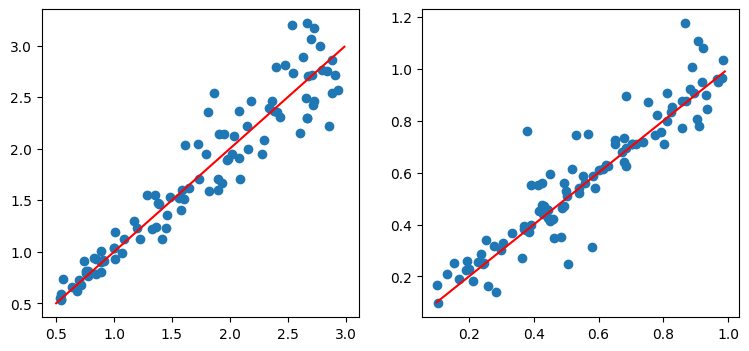

In [20]:
# ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
ndt = np.asanyarray(np.asanyarray(min_rt)/(1 + tf.math.log(1 + tf.math.exp(model.layers[-1].weights[-1]))))
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))

print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

print(pearsonr(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)[0], 
      pearsonr(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

436/436 [==============================] - 0s 285us/step
0.7455165665169861 0.7300425416710119
0.8668453944510724 0.8755158166997851


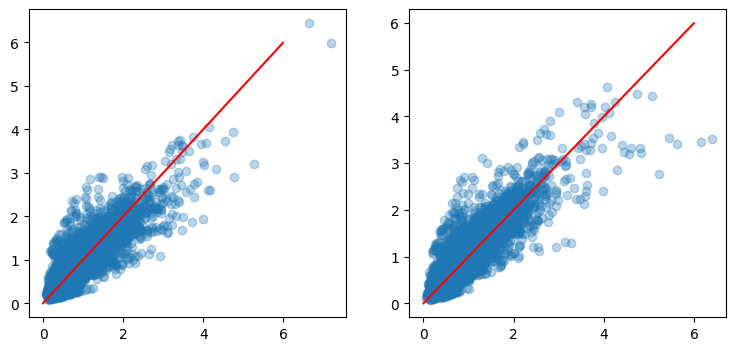

In [25]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

187/187 [==============================] - 0s 287us/step
0.746458942633577 0.7286333701539514
0.8682660481466796 0.8703523374772624


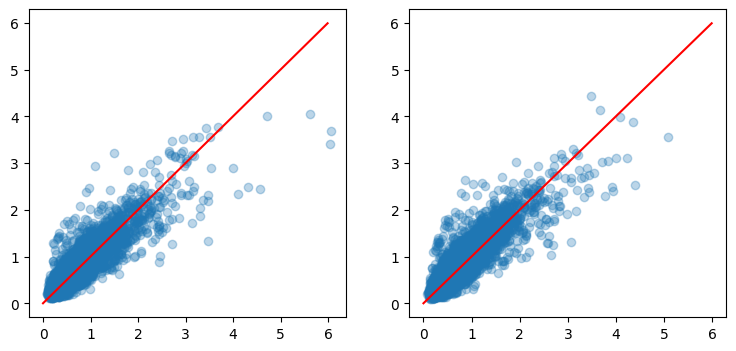

In [26]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');